## Importing required libraries

In [1]:
import pandas as pd
import numpy as np
import tweepy
import requests
import re
import json
import matplotlib.pyplot as plt
import datetime
import os
from collections import Counter

# Gathering Data

## 1- Uploading twitter_archive_enhanced.csv

In [2]:
twitter_archive_enhanced=pd.read_csv('twitter-archive-enhanced.csv')

## 2- Downloading image-predictions.tsv using requests method

In [3]:
# creat new folder if not exists

folder_name = 'image_predictions'

if not os.path.exists(folder_name):
    os.makedirs(folder_name)
    
# url from where the file shall be downloaded

url='https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'

#download the file and save it into the folder using requests method

response=requests.get(url)
with open (os.path.join(folder_name,url.split('/')[-1]),mode='wb') as file:
    file.write(response.content)
    
# Check the downloaded file:

os.listdir(folder_name)

['image-predictions.tsv']

In [4]:
# reading downloaded .tsv file into a python dataframe:

image_predections=pd.read_csv('image_predictions\image-predictions.tsv',sep='\t')

## 3- Create Twitter API, and Tweets data reading and saving into json .txt file

In [ ]:
# Do not run this code:

import tweepy
from tweepy import OAuthHandler
import json
from timeit import default_timer as timer

# Query Twitter API for each tweet in the Twitter archive and save JSON in a text file
# These are hidden to comply with Twitter's API terms and conditions
consumer_key = 'HIDDEN'
consumer_secret = 'HIDDEN'
access_token = 'HIDDEN'
access_secret = 'HIDDEN'

auth = OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth, wait_on_rate_limit=True)

# NOTE TO STUDENT WITH MOBILE VERIFICATION ISSUES:
# df_1 is a DataFrame with the twitter_archive_enhanced.csv file. You may have to
# change line 17 to match the name of your DataFrame with twitter_archive_enhanced.csv
# NOTE TO REVIEWER: this student had mobile verification issues so the following
# Twitter API code was sent to this student from a Udacity instructor
# Tweet IDs for which to gather additional data via Twitter's API
tweet_ids = twitter_archive_enhanced.tweet_id.values
len(tweet_ids)

# Query Twitter's API for JSON data for each tweet ID in the Twitter archive
count = 0
fails_dict = {}
start = timer()
# Save each tweet's returned JSON as a new line in a .txt file
with open('tweet_json.txt', 'w') as outfile:
    # This loop will likely take 20-30 minutes to run because of Twitter's rate limit
    for tweet_id in tweet_ids:
        count += 1
        print(str(count) + ": " + str(tweet_id))
        try:
            tweet = api.get_status(tweet_id, tweet_mode='extended')
            print("Success")
            json.dump(tweet._json, outfile)
            outfile.write('\n')
        except tweepy.TweepError as e:
            print("Fail")
            fails_dict[tweet_id] = e
            pass
end = timer()
print(end - start)
print(fails_dict)

## 4- Read tweet_json.txt file line by line into a pandas DataFrame with (at minimum) tweet ID, retweet count, and favorite count

In [5]:
# create empty list to read the file line by line

twitter_scrapped_list=[]

# read the file line by line using json.loads to convert a dictionary string
#to a dictionary and store it in the empty list

with open ('tweet-json.txt','r')as file:
    for line in file:
        tweet=json.loads(line)
        twitter_scrapped_list.append(tweet)
        
# convert the list of dictionaries into a dataframe

twitter_scrapped_df=pd.DataFrame(twitter_scrapped_list)

# select the required columns 'id_str','retweet_count','favorite_count'

twitter_scrapped_df=twitter_scrapped_df[['id_str','retweet_count','favorite_count']]

# Assessing Data

## 1- Visual Assessment

In [6]:
pd.set_option('display.max_colwidth',None)

In [7]:
twitter_archive_enhanced

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643555336193/photo/1,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421306343426/photo/1,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181378084864/photo/1,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557279858688/photo/1,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek https://t.co/AtUZn91f7f",NaN,NaN,NaN,"https://twitter.com/dog_rates/status/891327558926688256/photo/1,https://twitter.com/dog_rates/status/891327558926688256/photo/1",12,10,Franklin,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2351,666049248165822465,NaN,NaN,2015-11-16 00:24:50 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here we have a 1949 1st generation vulpix. Enjoys sweat tea and Fox News. Cannot be phased. 5/10 https://t.co/4B7cOc1EDq,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666049248165822465/photo/1,5,10,None,None,None,None,None
2352,666044226329800704,NaN,NaN,2015-11-16 00:04:52 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is a purebred Piers Morgan. Loves to Netflix and chill. Always looks like he forgot to unplug the iron. 6/10 https://t.co/DWnyCjf2mx,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666044226329800704/photo/1,6,10,a,None,None,None,None
2353,666033412701032449,NaN,NaN,2015-11-15 23:21:54 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here is a very happy pup. Big fan of well-maintained decks. Just look at that tongue. 9/10 would cuddle af https://t.co/y671yMhoiR,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666033412701032449/photo/1,9,10,a,None,None,None,None
2354,666029285002620928,NaN,NaN,2015-11-15 23:05:30 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is a western brown Mitsubishi terrier. Upset about leaf. Actually 2 dogs here. 7/10 would walk the shit out of https://t.co/r7mOb2m0UI,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666029285002620928/photo/1,7,10,a,None,None,None,None


In [8]:
image_predections

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True
...,...,...,...,...,...,...,...,...,...,...,...,...
2070,891327558926688256,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2,basset,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True
2071,891689557279858688,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1,paper_towel,0.170278,False,Labrador_retriever,0.168086,True,spatula,0.040836,False
2072,891815181378084864,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1,Chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True
2073,892177421306343426,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1,Chihuahua,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True


In [9]:
twitter_scrapped_df

,id_str,retweet_count,favorite_count
0,892420643555336193,8853,39467
1,892177421306343426,6514,33819
2,891815181378084864,4328,25461
3,891689557279858688,8964,42908
4,891327558926688256,9774,41048
...,...,...,...
2349,666049248165822465,41,111
2350,666044226329800704,147,311
2351,666033412701032449,47,128
2352,666029285002620928,48,132


## 2- Programmatic Assessment

In [10]:
twitter_archive_enhanced.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

In [11]:
twitter_archive_enhanced.describe()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator
count,2.356000e+03,7.800000e+01,7.800000e+01,1.810000e+02,1.810000e+02,2356.000000,2356.000000
mean,7.427716e+17,7.455079e+17,2.014171e+16,7.720400e+17,1.241698e+16,13.126486,10.455433
std,6.856705e+16,7.582492e+16,1.252797e+17,6.236928e+16,9.599254e+16,45.876648,6.745237
min,6.660209e+17,6.658147e+17,1.185634e+07,6.661041e+17,7.832140e+05,0.000000,0.000000
25%,6.783989e+17,6.757419e+17,3.086374e+08,7.186315e+17,4.196984e+09,10.000000,10.000000
50%,7.196279e+17,7.038708e+17,4.196984e+09,7.804657e+17,4.196984e+09,11.000000,10.000000
75%,7.993373e+17,8.257804e+17,4.196984e+09,8.203146e+17,4.196984e+09,12.000000,10.000000
max,8.924206e+17,8.862664e+17,8.405479e+17,8.874740e+17,7.874618e+17,1776.000000,170.000000


In [12]:
twitter_archive_enhanced.name.value_counts(dropna=False)

None        745
a            55
Charlie      12
Cooper       11
Lucy         11
           ... 
Oddie         1
Gert          1
Lizzie        1
Link          1
Kingsley      1
Name: name, Length: 957, dtype: int64

In [13]:
wrong_names=[]
for index, row in twitter_archive_enhanced.iterrows():  
    if row['name'][0].islower():
        wrong_names.append(row['name'])

In [14]:
Counter(wrong_names)

Counter({'such': 1,
         'a': 55,
         'quite': 4,
         'not': 2,
         'one': 4,
         'incredibly': 1,
         'mad': 2,
         'an': 7,
         'very': 5,
         'just': 4,
         'my': 1,
         'his': 1,
         'actually': 2,
         'getting': 2,
         'this': 1,
         'unacceptable': 1,
         'all': 1,
         'old': 1,
         'infuriating': 1,
         'the': 8,
         'by': 1,
         'officially': 1,
         'life': 1,
         'light': 1,
         'space': 1})

In [15]:
twitter_archive_enhanced.query('name=="None"').text

5       Here we have a majestic great white breaching off South Africa's coast. Absolutely h*ckin breathtaking. 13/10 (IG: tucker_marlo) #BarkWeek https://t.co/kQ04fDDRmh
7                           When you watch your owner call another dog a good boy but then they turn back to you and say you're a great boy. 13/10 https://t.co/v0nONBcwxq
12                                      Here's a puppo that seems to be on the fence about something haha no but seriously someone help her. 13/10 https://t.co/BxvuXk0UCm
24                                                        You may not have known you needed to see this today. 13/10 please enjoy (IG: emmylouroo) https://t.co/WZqNqygEyV
25               This... is a Jubilant Antarctic House Bear. We only rate dogs. Please only send dogs. Thank you... 12/10 would suffocate in floof https://t.co/4Ad1jzJSdp
                                                                                       ...                                                       

In [16]:
twitter_archive_enhanced.query('rating_denominator==170')

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
1120,731156023742988288,NaN,NaN,2016-05-13 16:15:54 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Say hello to this unbelievably well behaved squad of doggos. 204/170 would try to pet all at once https://t.co/yGQI3He3xv,NaN,NaN,NaN,https://twitter.com/dog_rates/status/731156023742988288/photo/1,204,170,this,None,None,None,None


In [17]:
twitter_archive_enhanced.query('rating_numerator==1776')

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
979,749981277374128128,NaN,NaN,2016-07-04 15:00:45 +0000,"<a href=""https://about.twitter.com/products/tweetdeck"" rel=""nofollow"">TweetDeck</a>",This is Atticus. He's quite simply America af. 1776/10 https://t.co/GRXwMxLBkh,NaN,NaN,NaN,https://twitter.com/dog_rates/status/749981277374128128/photo/1,1776,10,Atticus,None,None,None,None


In [18]:
twitter_archive_enhanced.rating_numerator.unique()

array([  13,   12,   14,    5,   17,   11,   10,  420,  666,    6,   15,
        182,  960,    0,   75,    7,   84,    9,   24,    8,    1,   27,
          3,    4,  165, 1776,  204,   50,   99,   80,   45,   60,   44,
        143,  121,   20,   26,    2,  144,   88], dtype=int64)

In [19]:
twitter_archive_enhanced[twitter_archive_enhanced['text'].str.contains(r"(\d+\.\d*\/\d+)")]

C:\Users\mohamed.ahegab\Anaconda3\lib\site-packages\pandas\core\strings.py:2001: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
45,883482846933004288,NaN,NaN,2017-07-08 00:28:19 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Bella. She hopes her smile made you smile. If not, she is also offering you her favorite monkey. 13.5/10 https://t.co/qjrljjt948",NaN,NaN,NaN,"https://twitter.com/dog_rates/status/883482846933004288/photo/1,https://twitter.com/dog_rates/status/883482846933004288/photo/1",5,10,Bella,None,None,None,None
340,832215909146226688,NaN,NaN,2017-02-16 13:11:49 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","RT @dog_rates: This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10 https://t.co/yBO5wu…",7.867091e+17,4.196984e+09,2016-10-13 23:23:56 +0000,https://twitter.com/dog_rates/status/786709082849828864/photo/1,75,10,Logan,None,None,None,None
695,786709082849828864,NaN,NaN,2016-10-13 23:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10 https://t.co/yBO5wuqaPS",NaN,NaN,NaN,https://twitter.com/dog_rates/status/786709082849828864/photo/1,75,10,Logan,None,None,None,None
763,778027034220126208,NaN,NaN,2016-09-20 00:24:34 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Sophie. She's a Jubilant Bush Pupper. Super h*ckin rare. Appears at random just to smile at the locals. 11.27/10 would smile back https://t.co/QFaUiIHxHq,NaN,NaN,NaN,https://twitter.com/dog_rates/status/778027034220126208/photo/1,27,10,Sophie,None,None,pupper,None
1689,681340665377193984,6.813394e+17,4.196984e+09,2015-12-28 05:07:27 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",I've been told there's a slight possibility he's checking his mirror. We'll bump to 9.5/10. Still a menace,NaN,NaN,NaN,NaN,5,10,None,None,None,None,None
1712,680494726643068929,NaN,NaN,2015-12-25 21:06:00 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here we have uncovered an entire battalion of holiday puppers. Average of 11.26/10 https://t.co/eNm2S6p9BD,NaN,NaN,NaN,https://twitter.com/dog_rates/status/680494726643068929/photo/1,26,10,None,None,None,None,None


In [20]:
twitter_archive_enhanced.rating_numerator.value_counts()

12      558
11      464
10      461
13      351
9       158
8       102
7        55
14       54
5        37
6        32
3        19
4        17
1         9
2         9
420       2
0         2
15        2
75        2
80        1
20        1
24        1
26        1
44        1
50        1
60        1
165       1
84        1
88        1
144       1
182       1
143       1
666       1
960       1
1776      1
17        1
27        1
45        1
99        1
121       1
204       1
Name: rating_numerator, dtype: int64

In [21]:
twitter_archive_enhanced.rating_denominator.unique()

array([ 10,   0,  15,  70,   7,  11, 150, 170,  20,  50,  90,  80,  40,
       130, 110,  16, 120,   2], dtype=int64)

In [22]:
twitter_archive_enhanced.rating_denominator.value_counts()

10     2333
11        3
50        3
80        2
20        2
2         1
16        1
40        1
70        1
15        1
90        1
110       1
120       1
130       1
150       1
170       1
7         1
0         1
Name: rating_denominator, dtype: int64

In [23]:
twitter_archive_enhanced.query('rating_denominator<10').text

313                                                                            @jonnysun @Lin_Manuel ok jomny I know you're excited but 960/00 isn't a valid rating, 13/10 is tho
516     Meet Sam. She smiles 24/7 &amp; secretly aspires to be a reindeer. \nKeep Sam smiling by clicking and sharing this link:\nhttps://t.co/98tB8y7y7t https://t.co/LouL5vdvxx
2335                                     This is an Albanian 3 1/2 legged  Episcopalian. Loves well-polished hardwood flooring. Penis on the collar. 9/10 https://t.co/d9NcXFKwLv
Name: text, dtype: object

In [24]:
twitter_archive_enhanced.query('rating_denominator>10').text

342                                                                                                               @docmisterio account started on 11/15/15
433                                                    The floofs have been released I repeat the floofs have been released. 84/70 https://t.co/NIYC820tmd
784           RT @dog_rates: After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https:/…
902                                                                         Why does this never happen at my front door... 165/150 https://t.co/HmwrdfEfUE
1068          After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https://t.co/XAVDNDaVgQ
1120                             Say hello to this unbelievably well behaved squad of doggos. 204/170 would try to pet all at once https://t.co/yGQI3He3xv
1165                                                                  

In [25]:
twitter_archive_enhanced.query('rating_numerator==420').text

188     @dhmontgomery We also gave snoop dogg a 420/10 but I think that predated your research
2074       After so many requests... here you go.\n\nGood dogg. 420/10 https://t.co/yfAAo1gdeY
Name: text, dtype: object

In [26]:
twitter_archive_enhanced.query('rating_numerator==1776').text

979    This is Atticus. He's quite simply America af. 1776/10 https://t.co/GRXwMxLBkh
Name: text, dtype: object

In [27]:
image_predections

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True
...,...,...,...,...,...,...,...,...,...,...,...,...
2070,891327558926688256,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2,basset,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True
2071,891689557279858688,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1,paper_towel,0.170278,False,Labrador_retriever,0.168086,True,spatula,0.040836,False
2072,891815181378084864,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1,Chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True
2073,892177421306343426,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1,Chihuahua,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True


In [28]:
image_predections.describe()

,tweet_id,img_num,p1_conf,p2_conf,p3_conf
count,2.075000e+03,2075.000000,2075.000000,2.075000e+03,2.075000e+03
mean,7.384514e+17,1.203855,0.594548,1.345886e-01,6.032417e-02
std,6.785203e+16,0.561875,0.271174,1.006657e-01,5.090593e-02
min,6.660209e+17,1.000000,0.044333,1.011300e-08,1.740170e-10
25%,6.764835e+17,1.000000,0.364412,5.388625e-02,1.622240e-02
50%,7.119988e+17,1.000000,0.588230,1.181810e-01,4.944380e-02
75%,7.932034e+17,1.000000,0.843855,1.955655e-01,9.180755e-02
max,8.924206e+17,4.000000,1.000000,4.880140e-01,2.734190e-01


In [29]:
image_predections.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   int64  
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [30]:
image_predections.p1.value_counts()

golden_retriever      150
Labrador_retriever    100
Pembroke               89
Chihuahua              83
pug                    57
                     ... 
bearskin                1
bee_eater               1
microphone              1
radio_telescope         1
cheeseburger            1
Name: p1, Length: 378, dtype: int64

In [31]:
twitter_scrapped_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354 entries, 0 to 2353
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id_str          2354 non-null   object
 1   retweet_count   2354 non-null   int64 
 2   favorite_count  2354 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 55.3+ KB


## Quality issues:


   * Data shall include only original ratings (no retweets)
   * Data Shall include only tweets that have images

   * twitter_archieve_enhanced table:
            1- name column has single letter a, an, the, etc. that does not reflect the actual name
            2- name column None data shall be converted to nan
            3- doggo, floofer, pupper, puppo columns None data shall be converted to nan
            4- rating_numerator is not accurate in some cases, ex: decimal values, ratings for more than 1 dog, etc.
            5- rating_denominator is not accurate in some cases, ex: ratings for more than 1 dog, etc.
            6- timestamp datatype is not datetime
            7- rows with more than one value for doggo, floofer, pupper,puppo like row 191, 200, 460, 531, etc.
    
   * image_predections table:
         1- P1, P2, P3 names are not all starting with capital letters, and has different structurs and separated by _ and -
         2- percentages for p_conf columns are all decimals
         3- non descriptive column names p1_conf, p2_conf, p3_conf
         4- consider only images of original tweets
         5- not all predections are dog breeds, and different predections per picture
         
   * twitter_scrapped_df table:
         1- id_str name shall be tweet_id to match other dataframes names
         2- id_str datatype shall be int64 to match other dataframes tweet_id datatype
    

## Tideness issues:
* twitter_archive_enhanced table:
    
    1- doggo, floofer, pupper, puppo columns shall be replaced by one column called stage
    
* twitter_scrapped_df:

    1- Can be added to twitter_archive enhanced, no need for special table

* image_predection:

    1- cahnge P1,P2,P3 columns to predection, confidence, Dog_breed


# Cleaning Data

## Define:

Remove all tweets that have no image data from twitter_archive_enhanced dataframe

## Code:

In [32]:
# creating a list of tweet_ids with images "tweets_with_image"
tweets_id_with_image = list(image_predections.tweet_id.unique())

In [33]:
# using dataframe.isin() method to filter the tweets data with images only from twitter_archive_enhanced
#https://www.geeksforgeeks.org/python-pandas-dataframe-isin/
with_image=twitter_archive_enhanced.tweet_id.isin(tweets_id_with_image)

In [34]:
# creating new df for tweets with images only
twitter_archive_clean=twitter_archive_enhanced[with_image]

# Testing:

In [35]:
len(tweets_id_with_image)

2075

In [36]:
with_image.sum()

2075

In [37]:
twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2075 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2075 non-null   int64  
 1   in_reply_to_status_id       23 non-null     float64
 2   in_reply_to_user_id         23 non-null     float64
 3   timestamp                   2075 non-null   object 
 4   source                      2075 non-null   object 
 5   text                        2075 non-null   object 
 6   retweeted_status_id         81 non-null     float64
 7   retweeted_status_user_id    81 non-null     float64
 8   retweeted_status_timestamp  81 non-null     object 
 9   expanded_urls               2075 non-null   object 
 10  rating_numerator            2075 non-null   int64  
 11  rating_denominator          2075 non-null   int64  
 12  name                        2075 non-null   object 
 13  doggo                       2075 

## Define:

Remove retweets and replies and keep only original tweets in twitter_archive_clean

## Code:

In [38]:
### Cleaning twitter_archive_clean:

# detect all retweets and put it in a list
retweet_entries = twitter_archive_clean.retweeted_status_id.notnull()
# check count of retweets and compare it with .info() output
twitter_archive_clean[retweet_entries].shape
#drop the retweets data from the twitter_archive_clean
twitter_archive_clean=twitter_archive_clean[~retweet_entries]

# detect all replies and put it in a list
reply_entries=twitter_archive_clean.in_reply_to_status_id.notnull()
# check count of replies and compare it with .info() output
twitter_archive_clean[reply_entries].shape
#Drop the replies data from the twitter_archive_clean
twitter_archive_clean=twitter_archive_clean[~reply_entries]
# Drop the columns of replies and retweets status
twitter_archive_clean.drop(['in_reply_to_status_id', 'in_reply_to_user_id','retweeted_status_id','retweeted_status_user_id','retweeted_status_timestamp'], axis=1, inplace=True)


## Testing:

In [39]:
twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1971 entries, 0 to 2355
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   tweet_id            1971 non-null   int64 
 1   timestamp           1971 non-null   object
 2   source              1971 non-null   object
 3   text                1971 non-null   object
 4   expanded_urls       1971 non-null   object
 5   rating_numerator    1971 non-null   int64 
 6   rating_denominator  1971 non-null   int64 
 7   name                1971 non-null   object
 8   doggo               1971 non-null   object
 9   floofer             1971 non-null   object
 10  pupper              1971 non-null   object
 11  puppo               1971 non-null   object
dtypes: int64(3), object(9)
memory usage: 200.2+ KB


## Define:

Remove retweets and replies and keep only original tweets in images predections 

## Code:

In [40]:
### Cleaning image_predections:

#list of tweet_ids in the cleaned archive
cleaned_tweet_ids=list(twitter_archive_clean.tweet_id)
#use .isin method to filter the cleaned tweets only from image_predections
no_retweets_replies=image_predections.tweet_id.isin(cleaned_tweet_ids)
# create clean image_predection dataframe
image_predections_clean=image_predections[no_retweets_replies]

## Testing:

In [41]:
image_predections_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1971 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  1971 non-null   int64  
 1   jpg_url   1971 non-null   object 
 2   img_num   1971 non-null   int64  
 3   p1        1971 non-null   object 
 4   p1_conf   1971 non-null   float64
 5   p1_dog    1971 non-null   bool   
 6   p2        1971 non-null   object 
 7   p2_conf   1971 non-null   float64
 8   p2_dog    1971 non-null   bool   
 9   p3        1971 non-null   object 
 10  p3_conf   1971 non-null   float64
 11  p3_dog    1971 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 159.8+ KB


In [42]:
image_predections_clean.duplicated().sum()

0

## Define:

Clean Dog Names in twitter_archive_clean

   * Remove None Values
   * Extract the correct name from text column
   * Set the name to nan if not exist in text

## Code:

In [43]:
### Cleaning None values
# checking if dog names exists in text column, and update the name column
# serach for "this is" in text column
pattern = re.compile(r'(?:this)\s{1}(?:is\s)([A-Za-z]+)')
# search for "name, named, name is, named is" in text column
pattern_2 = re.compile(r'(?:name(?:d)?)\s{1}(?:is\s)?([A-Za-z]+)')

# eterate over every row:
for index, row in twitter_archive_clean.iterrows():
    try:
        if row['name'] == "None":
# check if pattern exists, extract dog name and update the name column
            c_name = re.findall(pattern, row['text'])[0]
            twitter_archive_clean.loc[index,'name'] = twitter_archive_clean.loc[index,'name'].replace("None", c_name)
    except IndexError:
        try:
#check if pattern_2 exists, extract dog name and update the name column
            c_name = re.findall(pattern_2, row['text'])[0]
            twitter_archive_clean.loc[index,'name'] = twitter_archive_clean.loc[index,'name'].replace('None', c_name)
        except IndexError:
            twitter_archive_clean.loc[index,'name'] = ''

In [44]:
### detect all words starting with small letter, and try to extract the dog name from text if exists

wrong_names=[]
for index, row in twitter_archive_clean.iterrows():
    if row['name']=='':
        continue
    if row['name'][0].islower():
        wrong_names.append(row['name'])

wrong_list=Counter(wrong_names)

In [45]:
### extract dog names from text if exists and update name column
for wrong in wrong_list: 
    for index, row in twitter_archive_clean.iterrows():  
        try:
            if row['name'] == wrong:
                c_name = re.findall(pattern_2, row['text'])[0]
                twitter_archive_clean.loc[index,'name'] = twitter_archive_clean.loc[index,'name'].replace(wrong, c_name)
        except IndexError:
            twitter_archive_clean.loc[index,'name'] = ''



In [46]:
twitter_archive_clean.name.replace("",np.nan, inplace=True)

## Testing:

In [47]:
twitter_archive_clean.name.value_counts(dropna=False)

NaN          590
Charlie       11
Oliver        10
Cooper        10
Lucy          10
            ... 
Ralf           1
Oreo           1
Kody           1
Eve            1
Sprinkles      1
Name: name, Length: 938, dtype: int64

In [48]:
twitter_archive_clean.query('name=="None"')

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo


In [49]:
twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1971 entries, 0 to 2355
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   tweet_id            1971 non-null   int64 
 1   timestamp           1971 non-null   object
 2   source              1971 non-null   object
 3   text                1971 non-null   object
 4   expanded_urls       1971 non-null   object
 5   rating_numerator    1971 non-null   int64 
 6   rating_denominator  1971 non-null   int64 
 7   name                1381 non-null   object
 8   doggo               1971 non-null   object
 9   floofer             1971 non-null   object
 10  pupper              1971 non-null   object
 11  puppo               1971 non-null   object
dtypes: int64(3), object(9)
memory usage: 280.2+ KB


## Define:
Replace None data with nan for doggo, floofer, pupper, puppo columns

In [50]:
twitter_archive_clean.iloc[:, -4:  ] = twitter_archive_clean.iloc[:, -4:  ].replace('None',np.nan)

In [51]:
twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1971 entries, 0 to 2355
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   tweet_id            1971 non-null   int64 
 1   timestamp           1971 non-null   object
 2   source              1971 non-null   object
 3   text                1971 non-null   object
 4   expanded_urls       1971 non-null   object
 5   rating_numerator    1971 non-null   int64 
 6   rating_denominator  1971 non-null   int64 
 7   name                1381 non-null   object
 8   doggo               73 non-null     object
 9   floofer             8 non-null      object
 10  pupper              209 non-null    object
 11  puppo               23 non-null     object
dtypes: int64(3), object(9)
memory usage: 280.2+ KB


## Define

Adjust rating_denominator values not equal 10 according to data in 'text' column

## Code

In [52]:
# values less than 10 and their actual ratings exist in the text column
twitter_archive_clean.loc[516,'rating_denominator']=np.nan
twitter_archive_clean.loc[2335,'rating_denominator']=10

# values more than 10 and do not represent more than 1 dog and their actual ratings exist in the text column
twitter_archive_clean.loc[1068,'rating_denominator']=10
twitter_archive_clean.loc[1165,'rating_denominator']=10
twitter_archive_clean.loc[1202,'rating_denominator']=10
twitter_archive_clean.loc[1662,'rating_denominator']=10


In [53]:
twitter_archive_clean.rating_denominator.value_counts()

10.0     1959
50.0        2
80.0        2
150.0       1
120.0       1
110.0       1
40.0        1
90.0        1
170.0       1
70.0        1
Name: rating_denominator, dtype: int64

In [54]:
den_index=twitter_archive_clean.query('rating_denominator>10').index

In [55]:
# adjusting the ratings for more than one dog programmatically
dog_count={}
for i in den_index:
    #saving dog counts to be used to adjust numerators as well
    dog_count[i]=int(twitter_archive_clean.loc[i,'rating_denominator']/10)
    twitter_archive_clean.loc[i,'rating_denominator']=10


## Testing

In [56]:
twitter_archive_clean.query('rating_denominator<10')

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo


In [57]:
twitter_archive_clean.query('rating_denominator>10')

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo


In [58]:
twitter_archive_clean.rating_denominator.value_counts()

10.0    1970
Name: rating_denominator, dtype: int64

## Define

Adjust rating_nomerator values according to data in 'text' column

## Code

In [59]:
# adjust some values manually after checking the 'text' column data (with reference to denomenator findings)
twitter_archive_clean.loc[516,'rating_numerator']=np.nan
twitter_archive_clean.loc[2074,'rating_numerator']=np.nan
twitter_archive_clean.loc[979,'rating_numerator']=np.nan
twitter_archive_clean.loc[2335,'rating_numerator']=9
twitter_archive_clean.loc[1068,'rating_numerator']=14
twitter_archive_clean.loc[1165,'rating_numerator']=13
twitter_archive_clean.loc[1202,'rating_numerator']=11
twitter_archive_clean.loc[1662,'rating_numerator']=10

In [60]:
# adjusting the ratings for more than one dog programmatically (with reference to denomenator findings)

for key,values in dog_count.items():
    twitter_archive_clean.loc[key,'rating_numerator']=twitter_archive_clean.loc[key,'rating_numerator']/values

In [61]:
# adjust numerators with decimals manullay
twitter_archive_clean.loc[45, 'rating_numerator'] = 13.5
twitter_archive_clean.loc[695, 'rating_numerator'] = 9.75
twitter_archive_clean.loc[763, 'rating_numerator'] = 11.27
twitter_archive_clean.loc[1712, 'rating_numerator'] = 11.26

## Testing

In [62]:
for key,values in dog_count.items():
    print(twitter_archive_clean.loc[key,'rating_numerator'])

12.0
11.0
12.0
11.0
10.0
9.0
12.0
11.0
11.0
12.0
11.0


In [63]:
twitter_archive_clean[twitter_archive_clean['text'].str.contains(r"(\d+\.\d*\/\d+)")][['text','rating_numerator']]

C:\Users\mohamed.ahegab\Anaconda3\lib\site-packages\pandas\core\strings.py:2001: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


,text,rating_numerator
45,"This is Bella. She hopes her smile made you smile. If not, she is also offering you her favorite monkey. 13.5/10 https://t.co/qjrljjt948",13.50
695,"This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10 https://t.co/yBO5wuqaPS",9.75
763,This is Sophie. She's a Jubilant Bush Pupper. Super h*ckin rare. Appears at random just to smile at the locals. 11.27/10 would smile back https://t.co/QFaUiIHxHq,11.27
1712,Here we have uncovered an entire battalion of holiday puppers. Average of 11.26/10 https://t.co/eNm2S6p9BD,11.26


In [64]:
twitter_archive_clean.rating_numerator.value_counts()

12.00    450
10.00    419
11.00    398
13.00    254
9.00     151
8.00      95
7.00      51
14.00     34
6.00      32
5.00      32
3.00      19
4.00      15
2.00       9
1.00       4
9.75       1
0.00       1
11.26      1
13.50      1
11.27      1
Name: rating_numerator, dtype: int64

## Define:
* Convert timestamp to datetime
* Extract year, month and day to new columns
* Drop timestamp column


## Code:

In [65]:
#convertting timestamp to datetime
twitter_archive_clean['timestamp'] = pd.to_datetime(twitter_archive_clean['timestamp'])

#extractting year, month and day in new columns
twitter_archive_clean['year'] = twitter_archive_clean['timestamp'].dt.year
twitter_archive_clean['month'] = twitter_archive_clean['timestamp'].dt.month
twitter_archive_clean['day'] = twitter_archive_clean['timestamp'].dt.day

#drop timestamp column
twitter_archive_clean = twitter_archive_clean.drop('timestamp', 1)

## Testing:

In [66]:
twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1971 entries, 0 to 2355
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   tweet_id            1971 non-null   int64  
 1   source              1971 non-null   object 
 2   text                1971 non-null   object 
 3   expanded_urls       1971 non-null   object 
 4   rating_numerator    1968 non-null   float64
 5   rating_denominator  1970 non-null   float64
 6   name                1381 non-null   object 
 7   doggo               73 non-null     object 
 8   floofer             8 non-null      object 
 9   pupper              209 non-null    object 
 10  puppo               23 non-null     object 
 11  year                1971 non-null   int64  
 12  month               1971 non-null   int64  
 13  day                 1971 non-null   int64  
dtypes: float64(2), int64(4), object(8)
memory usage: 311.0+ KB


In [67]:
twitter_archive_clean.head()

,tweet_id,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,year,month,day
0,892420643555336193,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,https://twitter.com/dog_rates/status/892420643555336193/photo/1,13.0,10.0,Phineas,NaN,NaN,NaN,NaN,2017,8,1
1,892177421306343426,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",https://twitter.com/dog_rates/status/892177421306343426/photo/1,13.0,10.0,Tilly,NaN,NaN,NaN,NaN,2017,8,1
2,891815181378084864,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,https://twitter.com/dog_rates/status/891815181378084864/photo/1,12.0,10.0,Archie,NaN,NaN,NaN,NaN,2017,7,31
3,891689557279858688,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ,https://twitter.com/dog_rates/status/891689557279858688/photo/1,13.0,10.0,Darla,NaN,NaN,NaN,NaN,2017,7,30
4,891327558926688256,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek https://t.co/AtUZn91f7f","https://twitter.com/dog_rates/status/891327558926688256/photo/1,https://twitter.com/dog_rates/status/891327558926688256/photo/1",12.0,10.0,Franklin,NaN,NaN,NaN,NaN,2017,7,29


In [68]:
pd.set_option('display.max_rows',None)

## Define:
* check and clean rows with more than one entry for dogggo, pupper, puppo, floofer columns

## Code:

In [69]:
# check rows with more than or equal 2 different values for dogggo, pupper, puppo, floofer columns 
dog_stage=twitter_archive_clean[['doggo','floofer','pupper','puppo']].notnull().sum(axis=1)
dog_stage[dog_stage.apply(lambda x: x>=2)]

191     2
200     2
460     2
531     2
575     2
705     2
889     2
956     2
1063    2
1113    2
dtype: int64

In [70]:
# clean unappropriate values after checking the text column and the pictures
twitter_archive_clean.loc[191,'doggo']=np.nan
twitter_archive_clean.loc[200,'doggo']=np.nan
twitter_archive_clean.loc[460,'doggo']=np.nan
twitter_archive_clean.loc[575,'doggo']=np.nan
twitter_archive_clean.loc[705,'pupper']=np.nan
twitter_archive_clean.loc[956,'doggo']=np.nan
twitter_archive_clean.loc[956,'pupper']=np.nan

## Testing:

In [71]:
twitter_archive_clean.loc[191,:]

tweet_id                                                                                                                                                          855851453814013952
source                                                                                            <a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>
text                  Here's a puppo participating in the #ScienceMarch. Cleverly disguising her own doggo agenda. 13/10 would keep the planet habitable for https://t.co/cMhq16isel
expanded_urls                                                                                                        https://twitter.com/dog_rates/status/855851453814013952/photo/1
rating_numerator                                                                                                                                                                  13
rating_denominator                                                                             

In [72]:
twitter_archive_clean.loc[956,:]

tweet_id                                                                                                                                    751583847268179968
source                                                                      <a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>
text                  Please stop sending it pictures that don't even have a doggo or pupper in them. Churlish af. 5/10 neat couch tho https://t.co/u2c9c7qSg8
expanded_urls                                                                                  https://twitter.com/dog_rates/status/751583847268179968/photo/1
rating_numerator                                                                                                                                             5
rating_denominator                                                                                                                                          10
name                                          

## Define:

* convert dogggo, pupper, puppo, floofer columns to 1 column named dog_stages
* drop dogggo, pupper, puppo, floofer, source, text, and expanded_url columns

## Code:

In [73]:
 twitter_archive_clean['dog_stages']=twitter_archive_clean[['doggo', 'puppo', 'pupper', 'floofer']].stack().groupby(level=0).agg('_'.join)

In [74]:
twitter_archive_clean=twitter_archive_clean.drop(['doggo', 'puppo', 'pupper', 'floofer'], axis = 1)

In [75]:
twitter_archive_clean=twitter_archive_clean.drop(['source','text', 'expanded_urls'], axis = 1)

## Testing:

In [76]:
twitter_archive_clean

,tweet_id,rating_numerator,rating_denominator,name,year,month,day,dog_stages
0,892420643555336193,13.00,10.0,Phineas,2017,8,1,NaN
1,892177421306343426,13.00,10.0,Tilly,2017,8,1,NaN
2,891815181378084864,12.00,10.0,Archie,2017,7,31,NaN
3,891689557279858688,13.00,10.0,Darla,2017,7,30,NaN
4,891327558926688256,12.00,10.0,Franklin,2017,7,29,NaN
5,891087950875897856,13.00,10.0,NaN,2017,7,29,NaN
6,890971913173991426,13.00,10.0,Jax,2017,7,28,NaN
7,890729181411237888,13.00,10.0,NaN,2017,7,28,NaN
8,890609185150312448,13.00,10.0,Zoey,2017,7,27,NaN
9,890240255349198849,14.00,10.0,Cassie,2017,7,26,doggo


In [77]:
twitter_archive_clean.rating_numerator.value_counts()

12.00    450
10.00    419
11.00    398
13.00    254
9.00     151
8.00      95
7.00      51
14.00     34
6.00      32
5.00      32
3.00      19
4.00      15
2.00       9
1.00       4
9.75       1
0.00       1
11.26      1
13.50      1
11.27      1
Name: rating_numerator, dtype: int64

In [78]:
image_predections_clean.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


## Define:

* Rename image_predection_clean columns name to be more indicative

## Code:

In [79]:
img_cols = ['tweet_id', 'jpg_url', 'img_num', 
       'prediction_1', 'confidence_1', 'breed_1',
       'prediction_2', 'confidence_2', 'breed_2',
       'prediction_3', 'confidence_3', 'breed_3']
image_predections_clean.columns = img_cols

## Testing:

In [80]:
image_predections_clean.head()

,tweet_id,jpg_url,img_num,prediction_1,confidence_1,breed_1,prediction_2,confidence_2,breed_2,prediction_3,confidence_3,breed_3
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


## Define:
* reshape the image_predections_clean table
* change column names to be more indicative

## Code:

In [81]:
    # reshape the dataframe to solve (Column headers are values, not variable names)
    image_predections_clean=pd.wide_to_long(image_predections_clean, stubnames=['prediction', 'confidence', 'breed'], 
    i=['tweet_id', 'jpg_url', 'img_num'], j='prediction_level', sep="_").reset_index()

In [82]:
# change column names again to be more indicative
image_predections_clean.rename(columns={"prediction": "dog_breed", "breed": "is_dog"}, inplace=True)

## Testing:

In [83]:
image_predections_clean.head()

,tweet_id,jpg_url,img_num,prediction_level,dog_breed,confidence,is_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,1,Welsh_springer_spaniel,0.465074,True
1,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,2,collie,0.156665,True
2,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,3,Shetland_sheepdog,0.061428,True
3,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,1,redbone,0.506826,True
4,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,2,miniature_pinscher,0.074192,True


In [84]:
image_predections_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5913 entries, 0 to 5912
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   tweet_id          5913 non-null   int64  
 1   jpg_url           5913 non-null   object 
 2   img_num           5913 non-null   int64  
 3   prediction_level  5913 non-null   int64  
 4   dog_breed         5913 non-null   object 
 5   confidence        5913 non-null   float64
 6   is_dog            5913 non-null   bool   
dtypes: bool(1), float64(1), int64(3), object(2)
memory usage: 283.1+ KB


## Define:
* create cleaner version of image_predections_clean with:
        1- filtering out all is_dog=False to remove pictures with no doges predectied
        2- filter with heighest predection confidence to determine the most accurate breed predection

In [85]:
# create new copy of the dataframe
image_predection_cleaner=image_predections_clean.copy()

In [86]:
# drop all images without dogs
image_predection_cleaner.drop(image_predection_cleaner.query('is_dog==False').index,axis=0,inplace=True)

In [87]:
# filter by maximum confidence percentage
image_predection_cleanest=image_predection_cleaner.sort_values('confidence').drop_duplicates(['tweet_id'],keep='last')

## Testing:

In [88]:
image_predection_cleanest.head()

,tweet_id,jpg_url,img_num,prediction_level,dog_breed,confidence,is_dog
3829,752519690950500352,https://pbs.twimg.com/media/CnF8qVDWYAAh0g1.jpg,3,2,Labrador_retriever,0.000010,True
3628,745433870967832576,https://pbs.twimg.com/media/ClhQJUUWAAEVpBX.jpg,1,2,basset,0.000014,True
4912,818536468981415936,https://pbs.twimg.com/media/C1wGkYoVQAAuC_O.jpg,1,2,Welsh_springer_spaniel,0.000062,True
4234,776088319444877312,https://pbs.twimg.com/media/CsU4NKkW8AUI5eG.jpg,3,2,pug,0.000077,True
4505,792883833364439040,https://pbs.twimg.com/media/CwDjoH3WAAIniIs.jpg,3,3,standard_poodle,0.000083,True


In [89]:
image_predection_cleanest.tail()

,tweet_id,jpg_url,img_num,prediction_level,dog_breed,confidence,is_dog
2988,709566166965075968,https://pbs.twimg.com/media/Cdjiqi6XIAIUOg-.jpg,1,1,chow,0.999837,True
1404,675149409102012420,https://pbs.twimg.com/media/CV6czeEWEAEdChp.jpg,1,1,chow,0.999876,True
2550,697463031882764288,https://pbs.twimg.com/media/Ca3i7CzXIAMLhg8.jpg,1,1,Labrador_retriever,0.999885,True
4026,762464539388485633,https://pbs.twimg.com/media/CpTRc4DUEAAYTq6.jpg,4,1,chow,0.999953,True
441,668636665813057536,https://pbs.twimg.com/media/CUd5gBGWwAA0IVA.jpg,1,1,komondor,0.999956,True


In [90]:
image_predection_cleanest.is_dog.value_counts()

True    1666
Name: is_dog, dtype: int64

In [91]:
image_predection_cleanest.tweet_id.duplicated().sum()

0

In [92]:
image_predection_cleaner.tweet_id.duplicated().sum()

2708

## Define:
* rename id_str to be tweet_id in twitter_scrapped_df
* change the data type of tweet_id to int64 not str to match other dataframes

## Code:

In [93]:
# create a copy ofthe original dataframe
twitter_scrapped_clean=twitter_scrapped_df.copy()

In [94]:
#rename the id_str column
twitter_scrapped_clean.rename(columns={"id_str":"tweet_id"}, inplace=True)

In [95]:
# change datatype of tweet_id from str to int64
twitter_scrapped_clean.tweet_id=twitter_scrapped_clean.tweet_id.astype('int64')

## Testing:

In [96]:
twitter_scrapped_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354 entries, 0 to 2353
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   tweet_id        2354 non-null   int64
 1   retweet_count   2354 non-null   int64
 2   favorite_count  2354 non-null   int64
dtypes: int64(3)
memory usage: 55.3 KB


In [97]:
twitter_scrapped_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354 entries, 0 to 2353
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id_str          2354 non-null   object
 1   retweet_count   2354 non-null   int64 
 2   favorite_count  2354 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 55.3+ KB


## Define:
* merge twitter_scrapped_clean and twitter_archive_clean as there is no need to have them in seperate dataframes

## Code:

In [98]:
twitter_archive_master=pd.merge(twitter_archive_clean, twitter_scrapped_clean, on ='tweet_id', how= 'left' )

## Testing:

In [99]:
twitter_archive_master.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1971 entries, 0 to 1970
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   tweet_id            1971 non-null   int64  
 1   rating_numerator    1968 non-null   float64
 2   rating_denominator  1970 non-null   float64
 3   name                1381 non-null   object 
 4   year                1971 non-null   int64  
 5   month               1971 non-null   int64  
 6   day                 1971 non-null   int64  
 7   dog_stages          302 non-null    object 
 8   retweet_count       1971 non-null   int64  
 9   favorite_count      1971 non-null   int64  
dtypes: float64(2), int64(6), object(2)
memory usage: 169.4+ KB


## Define:
* Combine the inputs in the image_predection_cleanest with the master dataframe

## Code:

In [100]:
twitter_archive_master=pd.merge(twitter_archive_master, image_predection_cleanest, on ='tweet_id', how= 'left' )

## Testing:

In [101]:
twitter_archive_master.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1971 entries, 0 to 1970
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   tweet_id            1971 non-null   int64  
 1   rating_numerator    1968 non-null   float64
 2   rating_denominator  1970 non-null   float64
 3   name                1381 non-null   object 
 4   year                1971 non-null   int64  
 5   month               1971 non-null   int64  
 6   day                 1971 non-null   int64  
 7   dog_stages          302 non-null    object 
 8   retweet_count       1971 non-null   int64  
 9   favorite_count      1971 non-null   int64  
 10  jpg_url             1666 non-null   object 
 11  img_num             1666 non-null   float64
 12  prediction_level    1666 non-null   float64
 13  dog_breed           1666 non-null   object 
 14  confidence          1666 non-null   float64
 15  is_dog              1666 non-null   object 
dtypes: flo

# Storing Data:

In [102]:
# Store the master dataframe
twitter_archive_master.to_csv('twitter_archive_master.csv', index= False, encoding = 'utf-8')

In [103]:
# store the image_predection_clean
image_predections_clean.to_csv('image_predections_cleaned.csv', index= False, encoding = 'utf-8')

In [104]:
twitter_archive_master

,tweet_id,rating_numerator,rating_denominator,name,year,month,day,dog_stages,retweet_count,favorite_count,jpg_url,img_num,prediction_level,dog_breed,confidence,is_dog
0,892420643555336193,13.00,10.0,Phineas,2017,8,1,NaN,8853,39467,NaN,NaN,NaN,NaN,NaN,NaN
1,892177421306343426,13.00,10.0,Tilly,2017,8,1,NaN,6514,33819,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1.0,1.0,Chihuahua,0.323581,True
2,891815181378084864,12.00,10.0,Archie,2017,7,31,NaN,4328,25461,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1.0,1.0,Chihuahua,0.716012,True
3,891689557279858688,13.00,10.0,Darla,2017,7,30,NaN,8964,42908,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1.0,2.0,Labrador_retriever,0.168086,True
4,891327558926688256,12.00,10.0,Franklin,2017,7,29,NaN,9774,41048,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2.0,1.0,basset,0.555712,True
5,891087950875897856,13.00,10.0,NaN,2017,7,29,NaN,3261,20562,https://pbs.twimg.com/media/DF3HwyEWsAABqE6.jpg,1.0,1.0,Chesapeake_Bay_retriever,0.425595,True
6,890971913173991426,13.00,10.0,Jax,2017,7,28,NaN,2158,12041,https://pbs.twimg.com/media/DF1eOmZXUAALUcq.jpg,1.0,1.0,Appenzeller,0.341703,True
7,890729181411237888,13.00,10.0,NaN,2017,7,28,NaN,16716,56848,https://pbs.twimg.com/media/DFyBahAVwAAhUTd.jpg,2.0,1.0,Pomeranian,0.566142,True
8,890609185150312448,13.00,10.0,Zoey,2017,7,27,NaN,4429,28226,https://pbs.twimg.com/media/DFwUU__XcAEpyXI.jpg,1.0,1.0,Irish_terrier,0.487574,True
9,890240255349198849,14.00,10.0,Cassie,2017,7,26,doggo,7711,32467,https://pbs.twimg.com/media/DFrEyVuW0AAO3t9.jpg,1.0,1.0,Pembroke,0.511319,True


## Insights and Visulaization

## 1st Insight and Visualization: 

Most common breed is Golden_retriever

In [105]:
twitter_archive_master.dog_breed.value_counts()[:10]

golden_retriever      156
Labrador_retriever    106
Pembroke               94
Chihuahua              90
pug                    62
toy_poodle             50
chow                   48
Samoyed                42
Pomeranian             41
malamute               33
Name: dog_breed, dtype: int64

Text(0, 0.5, 'Type of dog')

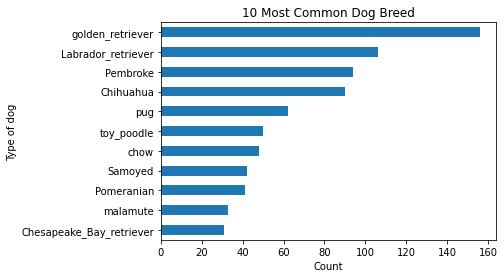

In [106]:
twitter_archive_master.dog_breed.value_counts()[10::-1].plot(kind='barh')
plt.title('10 Most Common Dog Breed')
plt.xlabel('Count')
plt.ylabel('Type of dog')

## 2nd Insight and Visualization:

Dog Stages classifications and most repeated stage

Text(0, 0.5, 'Count')

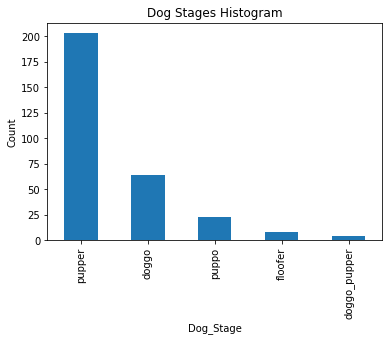

In [107]:
twitter_archive_master.dog_stages.value_counts().plot(kind='bar')
plt.title('Dog Stages Histogram')
plt.xlabel('Dog_Stage')
plt.ylabel('Count')

## 3rd Insight:
Lowest breed average rating is Japanese_spaniel and highest is Bouvier_des_Flandres 

In [108]:
twitter_archive_master.groupby('dog_breed').mean().rating_numerator.sort_values()

dog_breed
Japanese_spaniel                   5.000000
soft-coated_wheaten_terrier        8.500000
Scotch_terrier                     9.000000
Walker_hound                       9.000000
Tibetan_terrier                    9.250000
Ibizan_hound                       9.250000
dalmatian                          9.333333
Boston_bull                        9.416667
Welsh_springer_spaniel             9.500000
Dandie_Dinmont                     9.571429
miniature_schnauzer                9.600000
Norwich_terrier                    9.600000
redbone                            9.666667
Afghan_hound                       9.666667
Maltese_dog                        9.736842
Scottish_deerhound                 9.750000
Rhodesian_ridgeback                9.750000
Airedale                           9.833333
Newfoundland                       9.857143
Saint_Bernard                      9.857143
Mexican_hairless                   9.857143
English_setter                     9.875000
miniature_poodle      

## 4th Insight:

Heighest average favorite count is saluki breed

In [109]:
twitter_archive_master.groupby('dog_breed').mean().favorite_count.sort_values()

dog_breed
Brabancon_griffon                   885.000000
groenendael                        1156.500000
Japanese_spaniel                   1362.000000
Irish_wolfhound                    1534.000000
Tibetan_terrier                    1841.000000
standard_schnauzer                 2046.000000
Scottish_deerhound                 2305.000000
basenji                            2503.777778
Lhasa                              2659.800000
EntleBucher                        2678.000000
Maltese_dog                        2959.684211
toy_terrier                        3181.666667
Ibizan_hound                       3275.000000
redbone                            3296.333333
miniature_schnauzer                3409.000000
soft-coated_wheaten_terrier        3431.500000
miniature_poodle                   3456.875000
Dandie_Dinmont                     3464.571429
Shih-Tzu                           3593.350000
Scotch_terrier                     3624.000000
Rhodesian_ridgeback                4041.000000
Sus

## 5th Insight:

Heighest avearge retweet count is Bedlington_terrier breed

In [110]:
twitter_archive_master.groupby('dog_breed').mean().retweet_count.sort_values()

dog_breed
groenendael                        276.500000
Brabancon_griffon                  287.666667
Japanese_spaniel                   471.000000
Tibetan_terrier                    557.750000
EntleBucher                        706.000000
Rhodesian_ridgeback                769.000000
Irish_wolfhound                    819.000000
Lhasa                              826.000000
toy_terrier                        834.333333
Scottish_deerhound                 872.750000
basenji                            890.111111
standard_schnauzer                 928.000000
miniature_schnauzer                936.600000
miniature_poodle                   975.250000
Dandie_Dinmont                    1008.714286
soft-coated_wheaten_terrier       1061.785714
Welsh_springer_spaniel            1106.000000
redbone                           1113.000000
cairn                             1130.333333
curly-coated_retriever            1208.333333
Maltese_dog                       1238.263158
Sussex_spaniel          

## 6th Insight and Visualization:

The highest ratings do not receive the most retweets.

Text(0.5, 1.0, 'Retweet Counts by Ratings Scatter Plot')

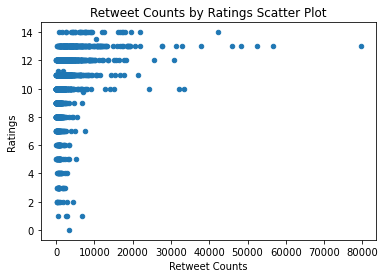

In [111]:
twitter_archive_master.plot(x='retweet_count', y='rating_numerator', kind='scatter')
plt.xlabel('Retweet Counts')
plt.ylabel('Ratings')
plt.title('Retweet Counts by Ratings Scatter Plot')

## 7th Insight and Visualization:
The heighest ratings do not receive the most favorite counts

Text(0.5, 1.0, 'Favorite Counts by Ratings Scatter Plot')

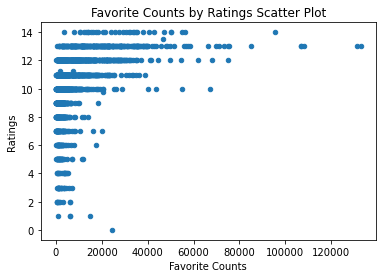

In [112]:
twitter_archive_master.plot(x='favorite_count', y='rating_numerator', kind='scatter')
plt.xlabel('Favorite Counts')
plt.ylabel('Ratings')
plt.title('Favorite Counts by Ratings Scatter Plot')